In [1]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import stdev, mean
from Function_4_Plot_xy_scatter_grid import drift_plot_grid, grid_plot

def get_hypot(dx,dy):
    hypot = abs(math.sqrt(dx**2 + dy**2))
    return hypot

def plot_nice(df:pd.DataFrame):
    # Clean start
    plt.close('all')

    # Create one figure and one axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Group by 'Direction' and plot each with error bars
    for direction, group in df.groupby('Direction'):
        group = group.sort_values('Time_in_min')
        ax.errorbar(
            group['Time_in_min'],
            group['Mean_px_drift'],
            yerr=group['SE_px_drift'],
            label=direction,
            capsize=3,
            marker='o',
            linestyle='-'
        )

    # Labeling and formatting
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Mean Pixel Drift')
    ax.set_title('Drift over Time by Direction')
    ax.legend(title='Direction')
    ax.grid(True)

    # Show one final plot
    fig.tight_layout()
    plt.show()

    plt.xlabel('Time (min)')
    plt.ylabel('Mean Pixel Drift')
    plt.title('Drift over Time by Direction')
    plt.legend(title='Direction')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def bplot(df:pd.DataFrame, x='Time_in_min'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=x, y='px_drift')

    plt.xlabel('Time (min)')
    plt.ylabel('Pixel Drift')
    plt.title('Distribution of Pixel Drift by Time')
    plt.xticks(rotation=45)  # Optional: Rotate if too crowded
    plt.tight_layout()
    plt.show()

In [2]:
filename = 'Coord_table_cv2_cross_correlation.csv'

all_data = pd.DataFrame()

# Assign directory
directory = input('Enter parent directory: ')

# Iterate over files in directory
for path, folders, files in os.walk(directory):
    for folder_name in folders:
        if filename in os.listdir(f'{path}/{folder_name}'):
            print(f'Content of {folder_name}')
            with open(f'{path}/{folder_name}/{filename}') as f:
                px_drift = []
                data = pd.read_csv(f)
                print(data)

                for i in range(len(data['Crosscor_tx_px'])):
                    px_drift.append(get_hypot(data['Crosscor_tx_px'][i],data['Crosscor_ty_px'][i]))
                data['px_drift'] = px_drift
                
                all_data = pd.concat([all_data,data]).reset_index(drop=True)
useful_data = all_data[['Direction','Time_in_min','px_drift']].fillna(0)
useful_data.sort_values('Direction')

Content of drift_data_22025-04-18 07:02:44.144779 - xcorr
     Unnamed: 0.1  Unnamed: 0  ... Crosscor_ty_microm  px_drift
0               0           0  ...                NaN       NaN
1               1           1  ...           0.078125  0.040000
2               2           2  ...           0.214844  0.136015
3               3           3  ...           0.039062  0.092195
4               4           4  ...           0.058594  0.104403
..            ...         ...  ...                ...       ...
112           112         112  ...           0.175781  0.102956
113           113         113  ...           0.214844  0.125300
114           114         114  ...           0.234375  0.120416
115           115         115  ...           0.234375  0.123693
116           116         116  ...           0.175781  0.094868

[117 rows x 18 columns]
Content of drift_data_22025-04-15 09:13:31.762158 - xcorr
     Unnamed: 0.1  Unnamed: 0  ... Crosscor_ty_microm  px_drift
0               0          

,Direction,Time_in_min,px_drift
724,X_negative,90,0.036056
374,X_negative,100,1.990628
375,X_negative,110,0.140357
376,X_negative,120,0.148661
842,X_negative,120,0.036056
...,...,...,...
178,Zero,90,0.100499
177,Zero,80,0.041231
176,Zero,70,0.044721
414,Zero,110,0.151327


In [ ]:
useful_data.to_csv(f'{directory}/drift_data.csv',index=False)

In [3]:
plot_data = []

direction_set = set(useful_data['Direction'].to_list())
for direction in direction_set:
    
    temp = useful_data[useful_data['Direction']==direction] # temporary df of only specific direction

    # find the mean for each Time_in_min
    for minutes in set(temp['Time_in_min'].to_list()):
        min_data = temp[temp['Time_in_min']==minutes] # temp df of only specific time in mins
        values = min_data['px_drift'].to_list()
        plot_data.append([direction,minutes,mean(values),stdev(values)])

plot_data = pd.DataFrame(plot_data, columns=['Direction','Time_in_min','Mean_px_drift','SE_px_drift'])
plot_data = plot_data.sort_values(['Direction','Time_in_min'])

In [ ]:
plot_data.to_csv(f'{directory}/mean_drift_data.csv',index=False)

In [4]:
import Function_4_Plot_xy_scatter_grid as f4
%load_ext autoreload
%autoreload 2

/home/marcus1/Documents/GitHub/OF-larger-delta-stage/code/test_scatter_hist.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


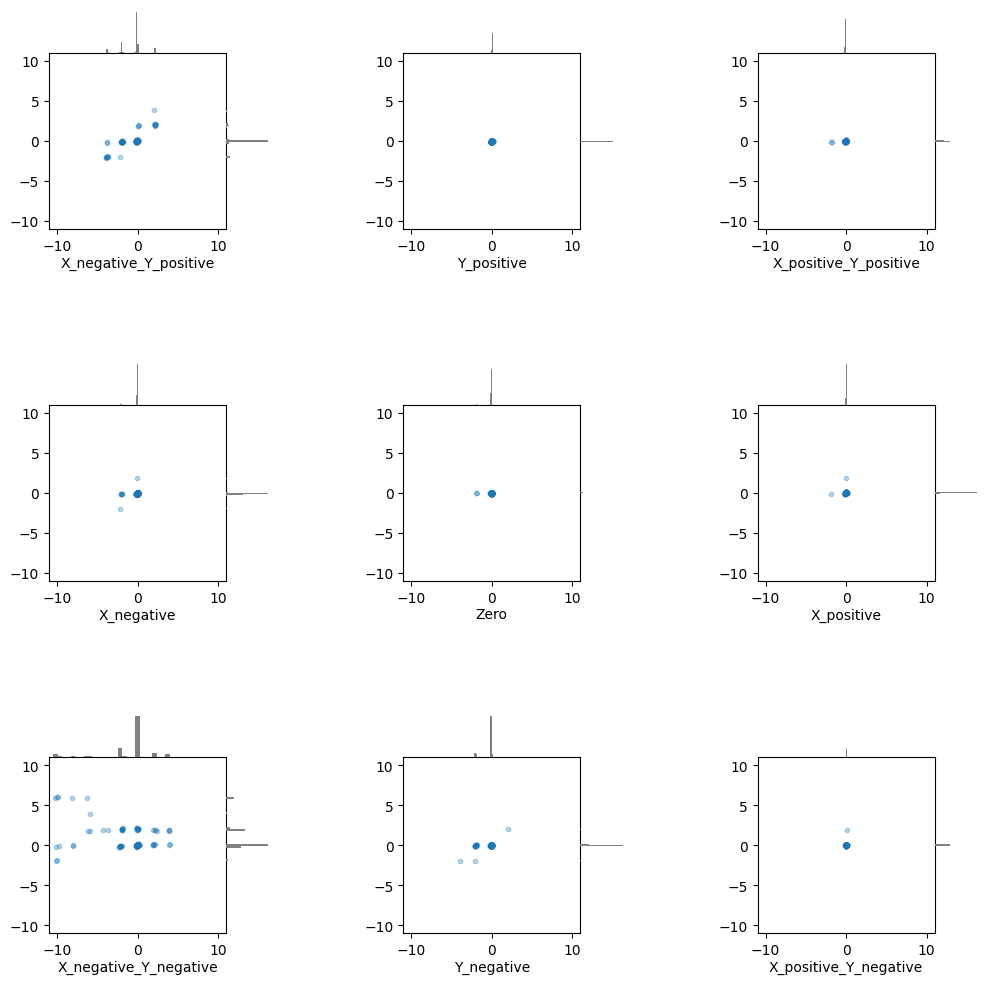

In [73]:
from test_scatter_hist import grid_plot
grid_plot(all_data)

In [74]:
import seaborn as sns

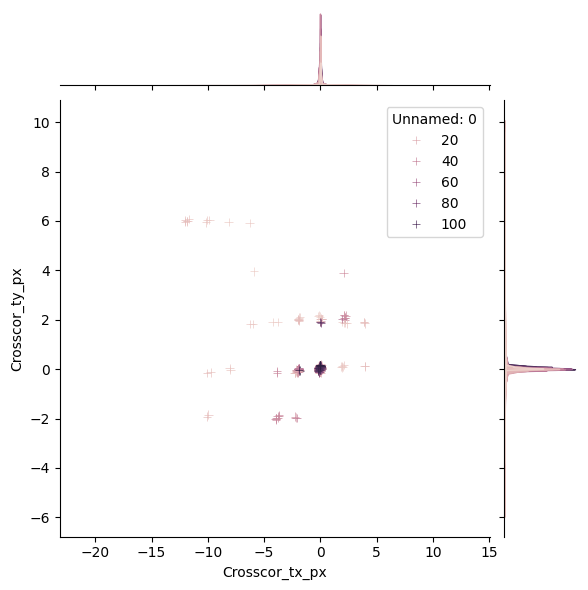

In [114]:
alpha = 9/all_data.shape[0]

ax = sns.jointplot(data=all_data,x='Crosscor_tx_px',y='Crosscor_ty_px', marker='+',legend='auto',hue='Unnamed: 0',dropna=True)

#sns.move_legend(obj=ax,loc='upper left', bbox_to_anchor=(1,1))

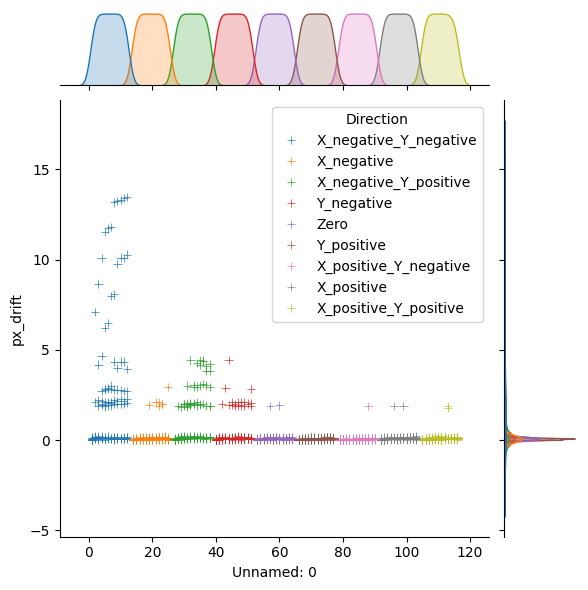

In [139]:
sns.jointplot(data=all_data,x='Unnamed: 0',y='px_drift',marker='+',dropna=True,hue='Direction')

In [125]:
import SeabornFig2Grid as sfg
import matplotlib.gridspec as gridspec

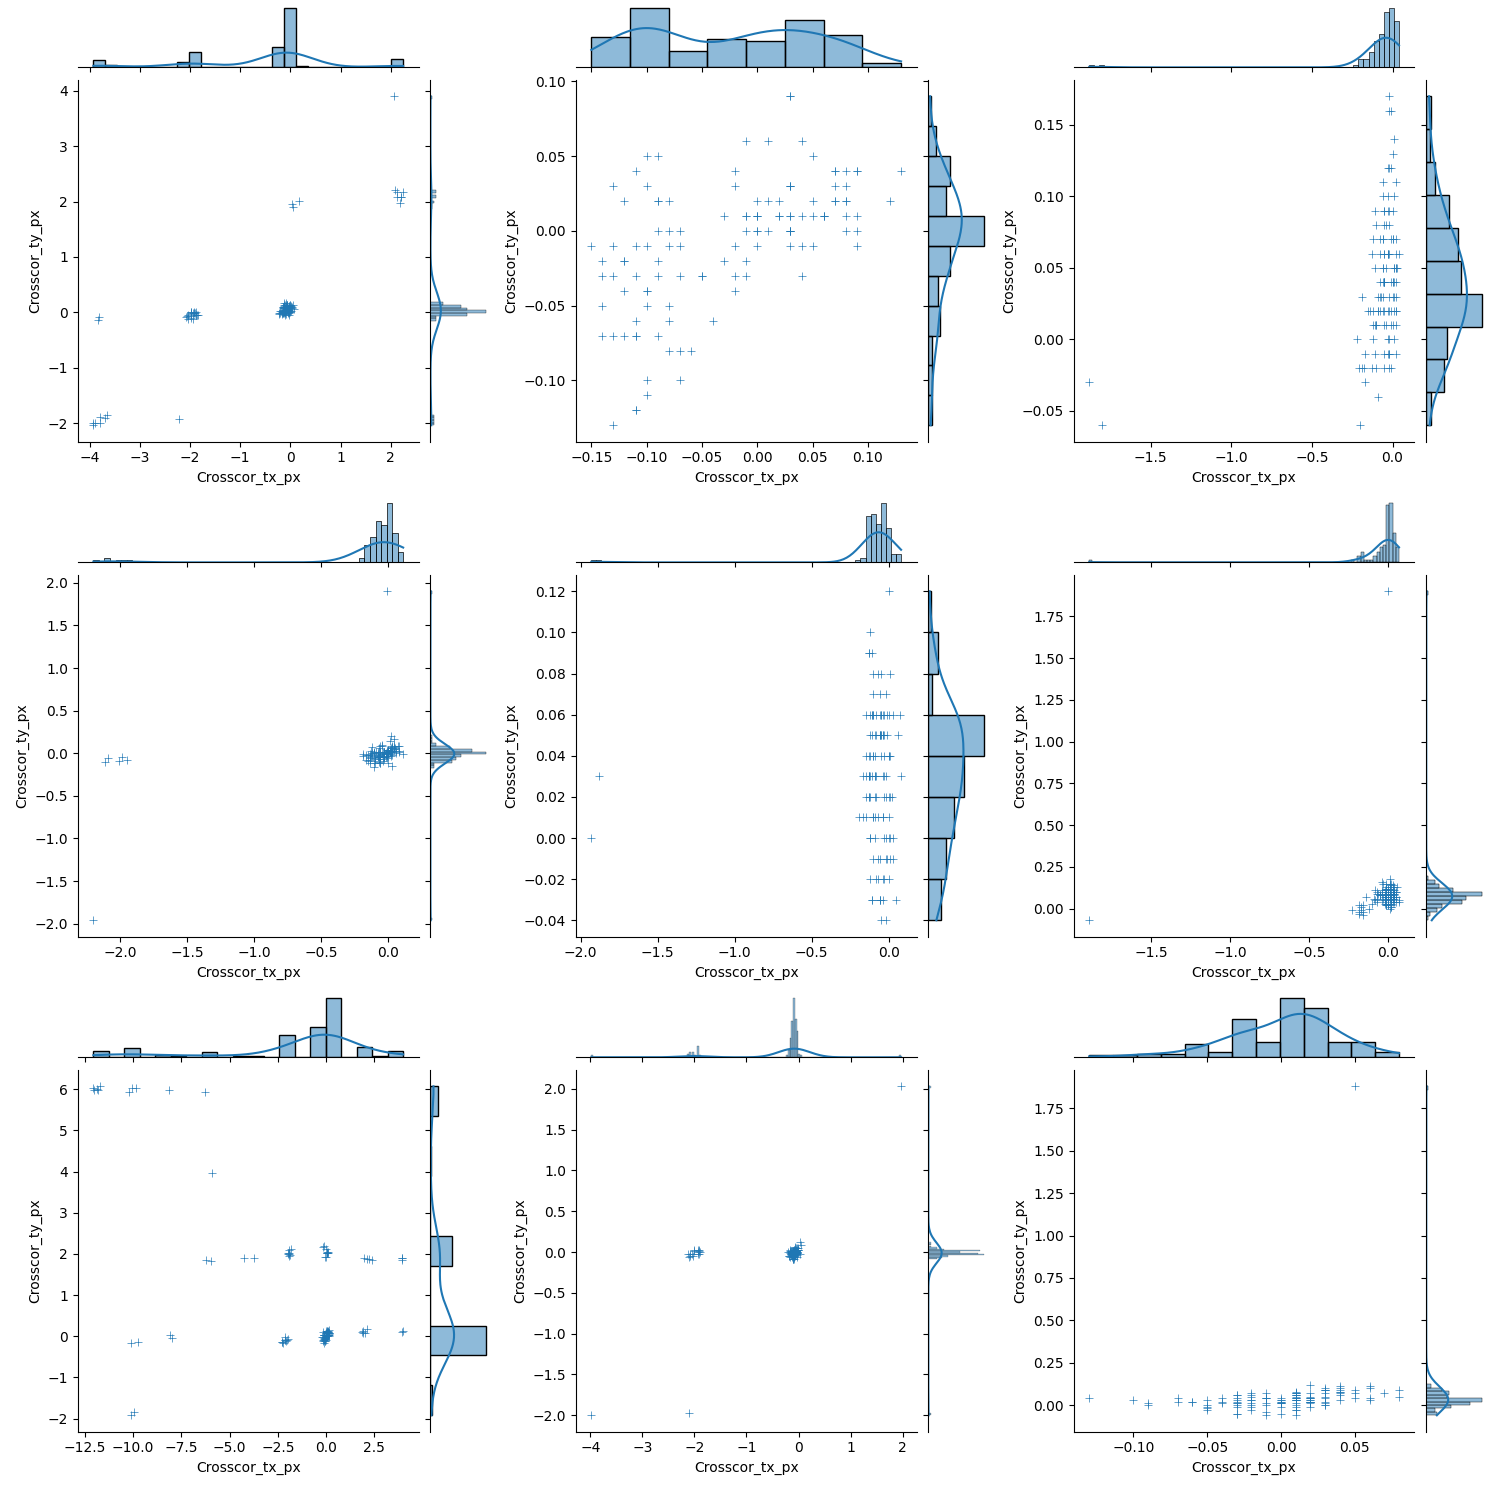

In [153]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

groups = all_data.groupby('Direction')
q = 0

for direction, (i,j) in direction_positions.items():
    group = groups.get_group(direction)
    figure = sns.jointplot(data=group,x='Crosscor_tx_px',y='Crosscor_ty_px',dropna=True,marker='+',space=0,marginal_kws=dict(kde=True))
    #figure.ax_marg_x.set_xlim(-10,10)
    #figure.ax_marg_y.set_ylim(-10,10)
    sfg.SeabornFig2Grid(figure, fig, gs[q])

    q += 1

gs.tight_layout(fig)


In [154]:
scale_factor = 1/5.025 #5.025px per 1um

In [167]:
all_data

,img_number,Image_path,Image_name,Protocol,ID,Slice_number,X_input_microm,Y_input_microm,Z_input_microm,t,Time_in_min,Direction,Crosscor_tx_px,Crosscor_ty_px,Crosscor_tx_microm,Crosscor_ty_microm,px_drift,tot_drift_microm
0,0,/media/marcus1/large_chungus/data_collection/d...,000_x-4500y-4500z0_t0_m0,long_term_drift,0,1,-4500,-4500,0,0,0,X_negative_Y_negative,NaN,NaN,NaN,NaN,NaN,NaN
1,1,/media/marcus1/large_chungus/data_collection/d...,001_x-4500y-4500z0_t1_m10,long_term_drift,1,1,-4500,-4500,0,1,10,X_negative_Y_negative,0.00,0.04,0.000000,0.007960,0.040000,0.007960
2,2,/media/marcus1/large_chungus/data_collection/d...,002_x-4500y-4500z0_t2_m20,long_term_drift,2,1,-4500,-4500,0,2,20,X_negative_Y_negative,0.08,0.11,0.015920,0.021891,0.136015,0.027068
3,3,/media/marcus1/large_chungus/data_collection/d...,003_x-4500y-4500z0_t3_m30,long_term_drift,3,1,-4500,-4500,0,3,30,X_negative_Y_negative,0.09,0.02,0.017910,0.003980,0.092195,0.018347
4,4,/media/marcus1/large_chungus/data_collection/d...,004_x-4500y-4500z0_t4_m40,long_term_drift,4,1,-4500,-4500,0,4,40,X_negative_Y_negative,0.10,0.03,0.019900,0.005970,0.104403,0.020777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,112,/media/marcus1/large_chungus/data_collection/d...,112_x4500y4500z0_t8_m80,long_term_drift,112,1,4500,4500,0,8,80,X_positive_Y_positive,-0.02,0.12,-0.003980,0.023881,0.121655,0.024210
1164,113,/media/marcus1/large_chungus/data_collection/d...,113_x4500y4500z0_t9_m90,long_term_drift,113,1,4500,4500,0,9,90,X_positive_Y_positive,-1.88,-0.03,-0.374129,-0.005970,1.880239,0.374177
1165,114,/media/marcus1/large_chungus/data_collection/d...,114_x4500y4500z0_t10_m100,long_term_drift,114,1,4500,4500,0,10,100,X_positive_Y_positive,0.01,0.14,0.001990,0.027861,0.140357,0.027932
1166,115,/media/marcus1/large_chungus/data_collection/d...,115_x4500y4500z0_t11_m110,long_term_drift,115,1,4500,4500,0,11,110,X_positive_Y_positive,-0.01,0.16,-0.001990,0.031841,0.160312,0.031903


In [166]:
all_data['Crosscor_tx_microm'] = all_data['Crosscor_tx_px'] * scale_factor
all_data['Crosscor_ty_microm'] = all_data['Crosscor_ty_px'] * scale_factor
all_data['tot_drift_microm'] = all_data['px_drift'] * scale_factor

In [ ]:
all_data.rename(columns={'Unnamed: 0': 'img_number'}, inplace=True)
all_data.drop(columns='Unnamed: 0.1', inplace=True)

In [ ]:
all_data['Date'] = all_data['Image_path'].str.extract(r'(\d{4}-\d{2}-\d{2})')
all_data['Date'] = pd.to_datetime(all_data['Date'])

In [190]:
all_data.to_csv(f'{directory}/all_drift_data.csv',index=False)

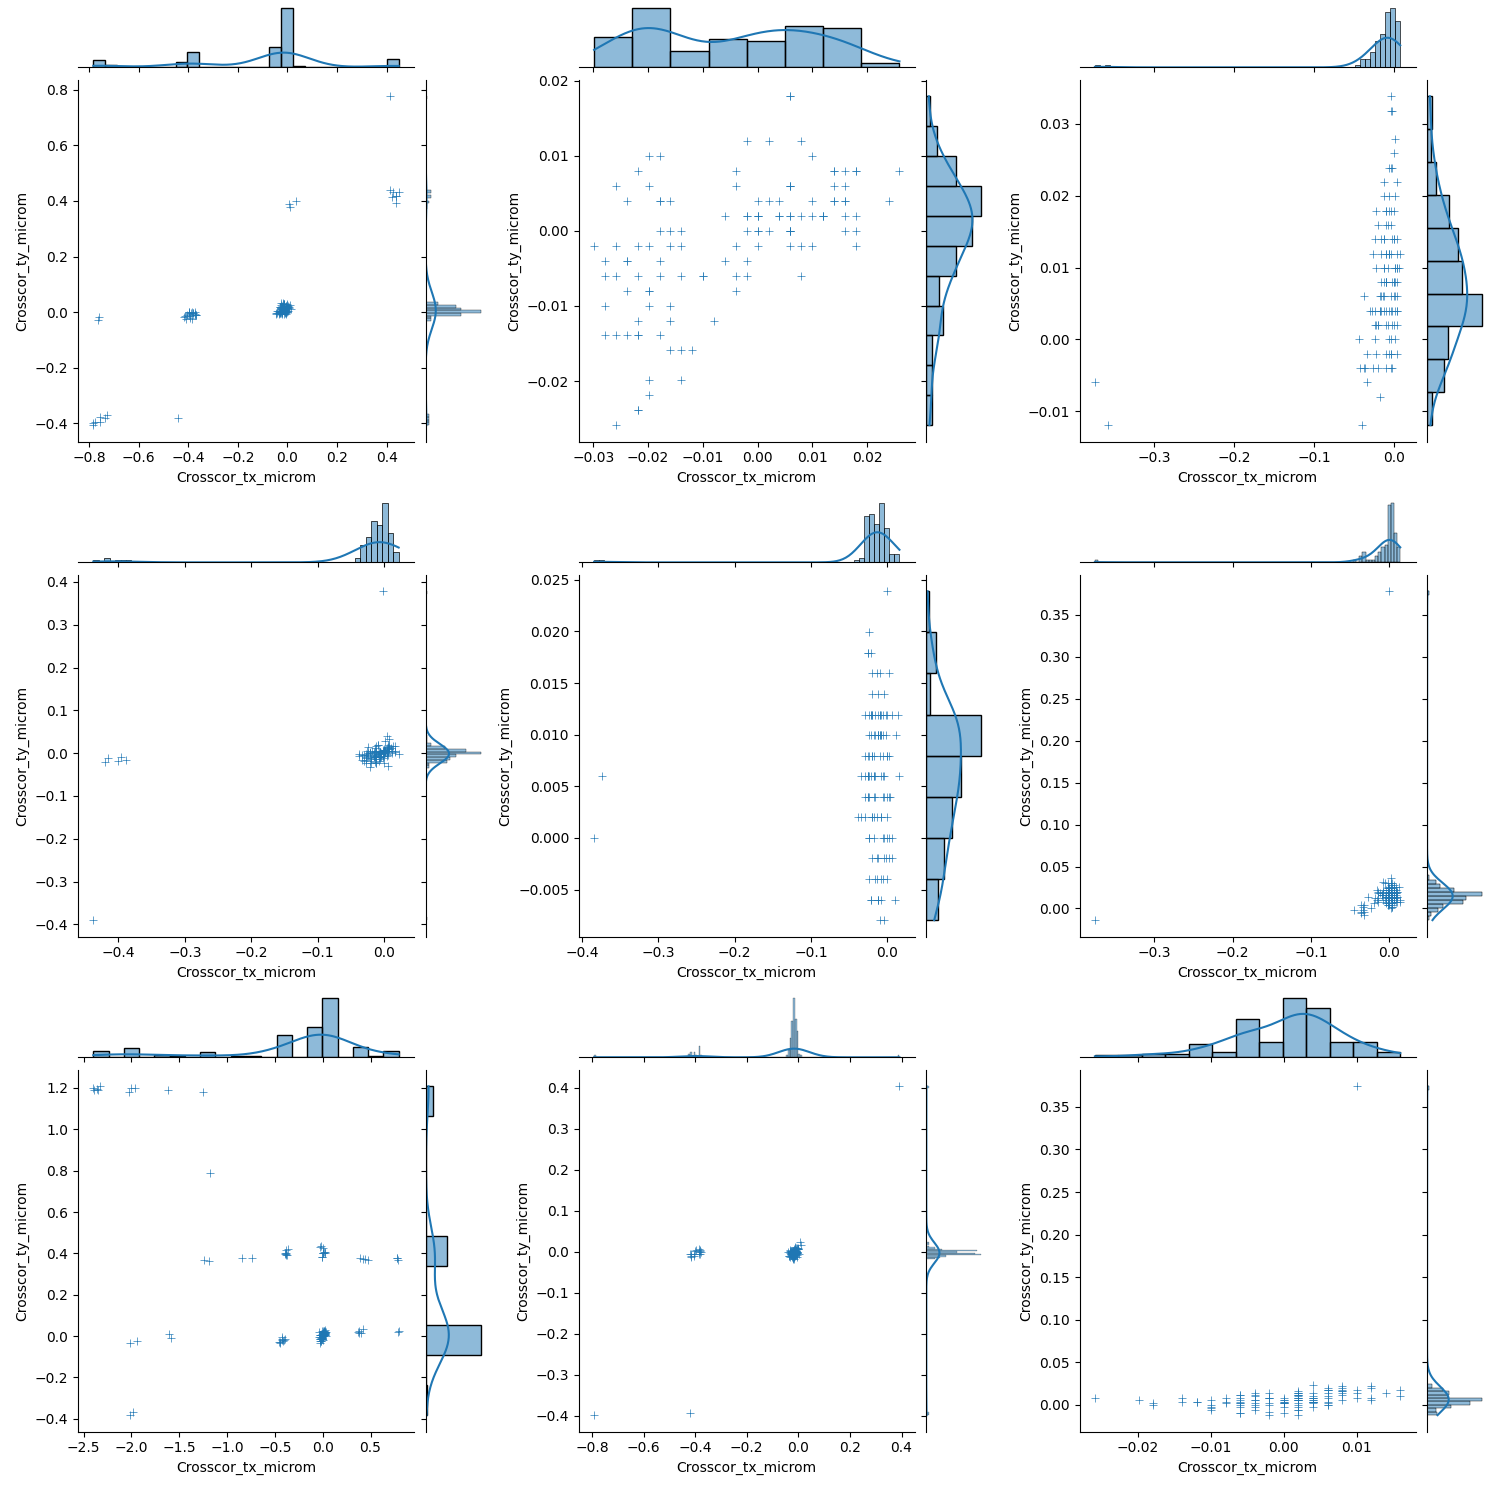

In [165]:
direction_positions = {
    'X_negative_Y_positive': (0, 0),
    'Y_positive':            (0, 1),
    'X_positive_Y_positive': (0, 2),
    'X_negative':            (1, 0),
    'Zero':                  (1, 1),
    'X_positive':            (1, 2),
    'X_negative_Y_negative': (2, 0),
    'Y_negative':            (2, 1),
    'X_positive_Y_negative': (2, 2),
    }

fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,3)

groups = all_data.groupby('Direction')
q = 0

for direction, (i,j) in direction_positions.items():
    group = groups.get_group(direction)
    figure = sns.jointplot(data=group,x='Crosscor_tx_microm',y='Crosscor_ty_microm',dropna=True,marker='+',space=0,marginal_kws=dict(kde=True))
    #figure.ax_marg_x.set_xlim(-10,10)
    #figure.ax_marg_y.set_ylim(-10,10)
    sfg.SeabornFig2Grid(figure, fig, gs[q])

    q += 1

gs.tight_layout(fig)


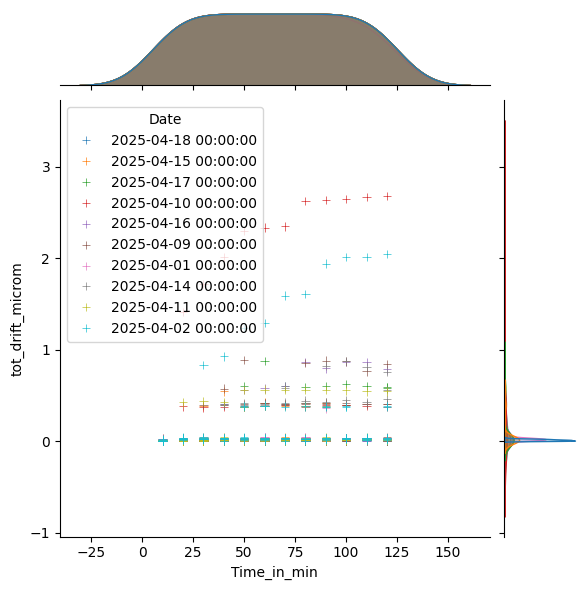

In [192]:
sns.jointplot(data=all_data,x='Time_in_min',y='tot_drift_microm',marker='+',dropna=True,hue='Date')

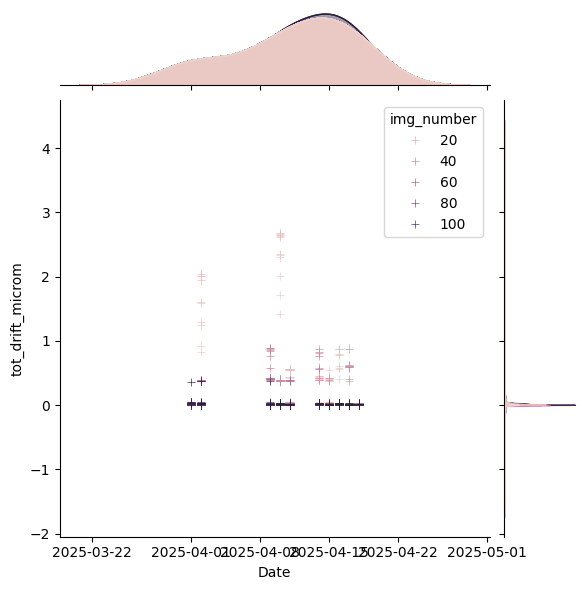

In [198]:
sns.jointplot(data=all_data,x='Date',y='tot_drift_microm',marker='+',dropna=True,hue='img_number')

<Axes: xlabel='Direction', ylabel='tot_drift_microm'>

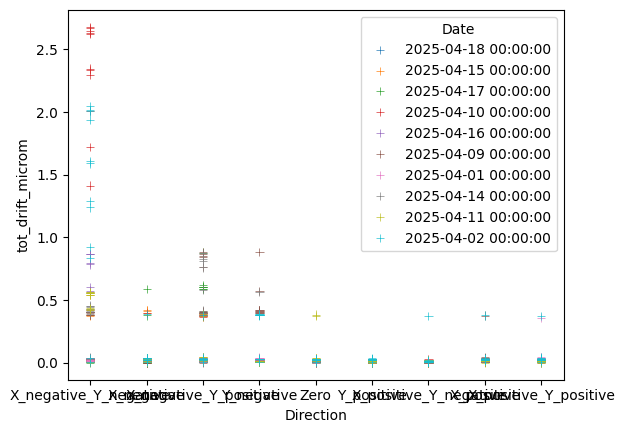

In [207]:
sns.scatterplot(data=all_data,x='Direction',y='tot_drift_microm',marker='+',hue='Date')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '2025-04-18'),
  Text(1, 0, '2025-04-15'),
  Text(2, 0, '2025-04-17'),
  Text(3, 0, '2025-04-10'),
  Text(4, 0, '2025-04-16'),
  Text(5, 0, '2025-04-09'),
  Text(6, 0, '2025-04-01'),
  Text(7, 0, '2025-04-14'),
  Text(8, 0, '2025-04-11'),
  Text(9, 0, '2025-04-02')])

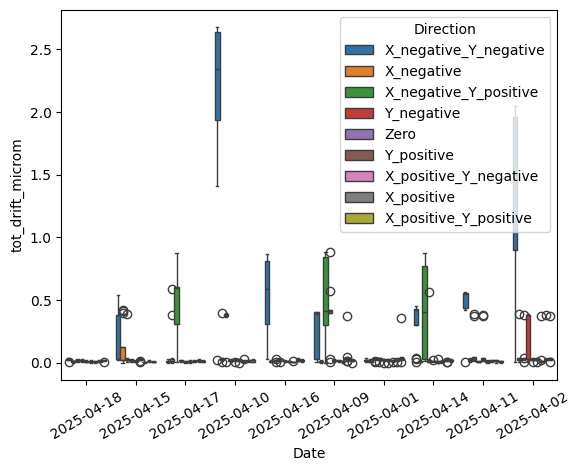

In [211]:
sns.boxplot(data=all_data,x='Date',y='tot_drift_microm', hue='Direction')
plt.xticks(rotation=30)